In [ ]:
%cd '/content/drive/MyDrive/CSE519/Project'

/content/drive/MyDrive/CSE519/Project


In [ ]:
%ls

delays.csv           masterData.csv  neural_model_architecture.pdf
dummy_clustered.csv  model.png       output.csv


In [ ]:
!python --version

Python 3.10.12


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Read the data
target_variable = 'DepDelay'
df = pd.read_csv('masterData.csv', index_col=False, nrows=50)
df['prcp'].fillna(0, inplace=True)
df.dropna(inplace=True)
df[target_variable] = df[target_variable].apply(lambda x: 0 if x < 0 else x)

# Define categorical and numerical columns
categorical_columns = ['Origin', 'Tail_Number', 'OriginCityName', 'Dest', 'DestCityName']
numerical_columns = [col for col in df.columns if col not in [target_variable] + categorical_columns]

# Label encode categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[numerical_columns + categorical_columns], df[target_variable], test_size=0.2, random_state=42)

# Standardize numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Define the embedding sizes for categorical columns
embedding_sizes = [(len(df[col].unique()), min(50, len(df[col].unique()) // 2 + 1)) for col in categorical_columns]

# Define Keras model
def create_model(embedding_sizes, num_numerical_cols):
    # Input layers
    input_layers = []
    embedding_layers = []

    for col, (num_classes, embedding_dim) in zip(categorical_columns, embedding_sizes):
        input_layer = Input(shape=(1,), name=f'{col}_input')
        embedding_layer = Embedding(input_dim=num_classes, output_dim=embedding_dim, input_length=1)(input_layer)
        flat_embedding = Flatten()(embedding_layer)  # Flatten the embeddings
        input_layers.append(input_layer)
        embedding_layers.append(flat_embedding)

    num_input = Input(shape=(num_numerical_cols,), name='numerical_input')
    input_layers.append(num_input)

    # Concatenate flattened embedding and numerical inputs
    concat_layers = Concatenate()(embedding_layers + [num_input])

    # Fully connected layers
    fc_layers = [Dense(10, activation='relu')(concat_layers),
                 Dense(5, activation='relu')(Dense(10, activation='relu')(concat_layers))]

    # Output layer
    output = Dense(1, activation='linear')(fc_layers[-1])

    model = Model(inputs=input_layers, outputs=output)
    return model

# Instantiate the model
model = create_model(embedding_sizes, len(numerical_columns))


from tensorflow.keras.utils import plot_model

# Save the plot to a file
# plot_model(model, to_file='neural_model_architecture.pdf', show_shapes=True, show_layer_names=True)
# plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Origin_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Tail_Number_input (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 OriginCityName_input (Inpu  [(None, 1)]                  0         []                            
 tLayer)                                                                                          
                                                                                              

#Regression

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4000])) that is different to the input size (torch.Size([4000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RMSE: 92.1419448852539, MAE: 30.902542114257812


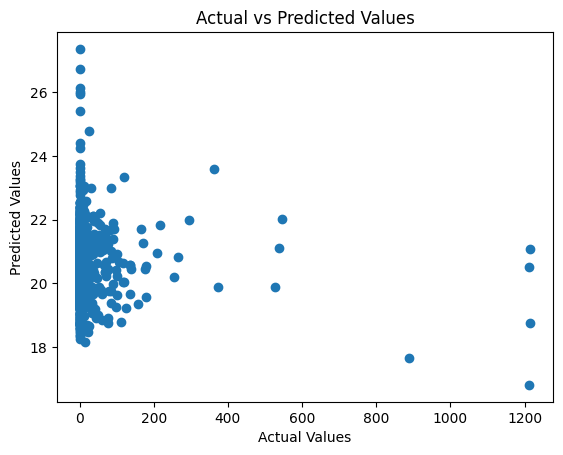

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('dummy_clustered.csv')

# List of boolean columns
bool_columns = ['Origin_0', 'Origin_1', 'Origin_2', 'Tail_Number_0', 'Tail_Number_1', 'Tail_Number_2',
                'OriginCityName_0', 'OriginCityName_1', 'OriginCityName_2', 'Dest_0', 'Dest_1', 'Dest_2',
                'DestCityName_0', 'DestCityName_1', 'DestCityName_2']

# Convert boolean columns to 1 or 0
df[bool_columns] = df[bool_columns].astype(int)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'DepDelay' is the target column
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'DepDelay' is the target column
target_column = 'DepDelay'

# Split the data into features (X) and target variable (y)
X = df.drop(columns=[target_column])
y = df[target_column]

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train.values)
y_train_tensor = torch.Tensor(y_train.values)
X_test_tensor = torch.Tensor(X_test.values)
y_test_tensor = torch.Tensor(y_test.values)

# Normalize your data if needed
# ...

# Define a deeper neural network model with dropout
class DeeperNeuralNetworkWithDropout(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.5):
        super(DeeperNeuralNetworkWithDropout, self).__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(nn.ReLU())

            # Add dropout layer after the first and second hidden layers
            if i == 0 or i == 1:
                layers.append(nn.Dropout(dropout_rate))

        # Remove the last ReLU layer
        layers = layers[:-1]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Initialize a deeper model with dropout, loss function, and optimizer
input_size = len(X.columns)
hidden_sizes = [128, 64, 32]  # Example: You can adjust the number of neurons in each hidden layer
output_size = 1
dropout_rate = 0.5  # Example: You can adjust the dropout rate
deeper_model_with_dropout = DeeperNeuralNetworkWithDropout(input_size, hidden_sizes, output_size, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(deeper_model_with_dropout.parameters(), lr=0.001)

# Move model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeper_model_with_dropout.to(device)
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# Training
num_epochs = 100
for epoch in range(num_epochs):
    deeper_model_with_dropout.train()
    optimizer.zero_grad()
    outputs = deeper_model_with_dropout(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
deeper_model_with_dropout.eval()
with torch.no_grad():
    predictions = deeper_model_with_dropout(X_test_tensor)
    rmse = torch.sqrt(criterion(predictions, y_test_tensor))
    mae = torch.abs(predictions - y_test_tensor).mean()

print(f"RMSE: {rmse.item()}, MAE: {mae.item()}")

# Visualization
import matplotlib.pyplot as plt
plt.scatter(y_test_tensor.cpu().numpy(), predictions.cpu().numpy())
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


#Classification

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans


In [ ]:
df = pd.read_csv('dummy_clustered.csv')
df['DepDelay']

0        2.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
4995     0.0
4996    41.0
4997     0.0
4998    86.0
4999     0.0
Name: DepDelay, Length: 5000, dtype: float64

In [ ]:
df['DepDelay'] = df['DepDelay'].apply(lambda x: 0 if x == 0 else 1)
df.dtypes

Year                               float64
Month                              float64
DayofMonth                         float64
temp                               float64
dwpt                               float64
prcp                               float64
wdir                               float64
wspd                               float64
pres                               float64
coco                               float64
DayOfWeek                          float64
Flight_Number_Marketing_Airline    float64
DepTime                            float64
TaxiOut                            float64
TaxiIn                             float64
DepDelay                             int64
Origin_0                              bool
Origin_1                              bool
Origin_2                              bool
Tail_Number_0                         bool
Tail_Number_1                         bool
Tail_Number_2                         bool
OriginCityName_0                      bool
OriginCityN

In [ ]:
bool_columns = ['Origin_0', 'Origin_1', 'Origin_2', 'Tail_Number_0', 'Tail_Number_1', 'Tail_Number_2',
                'OriginCityName_0', 'OriginCityName_1', 'OriginCityName_2', 'Dest_0', 'Dest_1', 'Dest_2',
                'DestCityName_0', 'DestCityName_1', 'DestCityName_2']

# Convert boolean columns to 1 or 0
df[bool_columns] = df[bool_columns].astype(int)
df.dtypes

Year                               float64
Month                              float64
DayofMonth                         float64
temp                               float64
dwpt                               float64
prcp                               float64
wdir                               float64
wspd                               float64
pres                               float64
coco                               float64
DayOfWeek                          float64
Flight_Number_Marketing_Airline    float64
DepTime                            float64
TaxiOut                            float64
TaxiIn                             float64
DepDelay                             int64
Origin_0                             int64
Origin_1                             int64
Origin_2                             int64
Tail_Number_0                        int64
Tail_Number_1                        int64
Tail_Number_2                        int64
OriginCityName_0                     int64
OriginCityN

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       623
           1       0.60      0.51      0.55       377

    accuracy                           0.69      1000
   macro avg       0.66      0.65      0.66      1000
weighted avg       0.68      0.69      0.68      1000



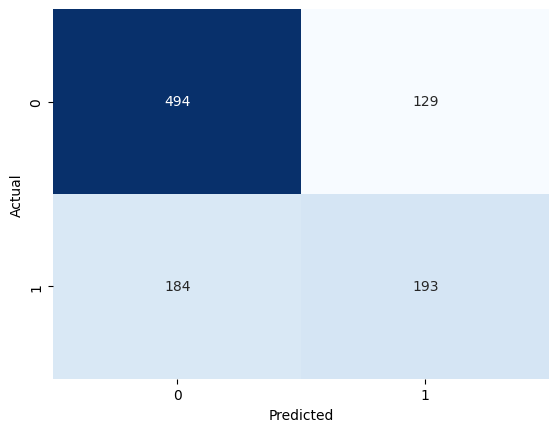

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your dataframe
# Replace 'df' with the actual name of your dataframe if it's different

# Select features and target variable
X = df.drop('DepDelay', axis=1).values
y = df['DepDelay'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the more complex neural network
class ComplexClassifier(nn.Module):
    def __init__(self, input_size):
        super(ComplexClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model
input_size = X_train.shape[1]
model = ComplexClassifier(input_size)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor.to(device)).cpu().numpy()
    y_pred = (y_pred_probs >= 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#previous


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from kneed import KneeLocator


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Starter code
target_variable = 'DepDelay'
df = pd.read_csv('masterData.csv', index_col=False, nrows=50000)
df['prcp'].fillna(0, inplace=True)
df.dropna(inplace=True)
df[target_variable] = df[target_variable].apply(lambda x: 0 if x < 0 else x)

categorical_columns = ['Origin', 'Tail_Number', 'OriginCityName', 'Dest', 'DestCityName']
numerical_columns = [col for col in df.columns if col not in [target_variable] + categorical_columns]

# Create a new DataFrame to store the target encoding results
target_encoded_df = df.copy()

# Iterate over each categorical column
for cat_column in categorical_columns:
    # Create a dictionary mapping each category to its median 'DepDelay'
    encoding_map = df.groupby(cat_column)[target_variable].mean().to_dict()

    # Map the target encoding back to the original DataFrame
    target_encoded_df[cat_column] = target_encoded_df[cat_column].map(encoding_map)

# Now, target_encoded_df contains the original DataFrame with categorical columns replaced by their median 'DepDelay'
target_encoded_df

,Year,Month,DayofMonth,Origin,CRSDepTime,temp,dwpt,rhum,prcp,wdir,...,DayOfWeek,Flight_Number_Marketing_Airline,Tail_Number,OriginCityName,Dest,DestCityName,DepTime,TaxiOut,TaxiIn,DepDelay
29,2018,1,22,7.777778,1845,10.1,4.0,66.0,0.0,60.0,...,1,4443,11.750000,7.777778,21.057143,21.057143,1847.0,41.0,10.0,2.0
30,2018,1,22,7.777778,1845,10.1,4.0,66.0,0.0,60.0,...,1,2398,0.000000,7.777778,16.444867,16.444867,1843.0,30.0,8.0,0.0
31,2018,1,22,7.777778,1845,10.1,4.0,66.0,0.0,60.0,...,1,1437,0.000000,7.777778,11.679348,11.679348,1837.0,37.0,7.0,0.0
49,2018,1,28,7.777778,1835,9.1,7.4,89.0,0.3,340.0,...,7,4443,0.000000,7.777778,21.057143,21.057143,1828.0,16.0,6.0,0.0
50,2018,1,28,7.777778,1835,9.1,7.4,89.0,0.3,340.0,...,7,1696,14.666667,7.777778,6.565217,6.565217,1831.0,19.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49955,2018,1,23,17.141748,755,16.7,16.1,96.0,1.3,210.0,...,2,5082,1.500000,17.141748,20.166667,20.166667,751.0,29.0,4.0,0.0
49956,2018,1,23,17.141748,755,16.7,16.1,96.0,1.3,210.0,...,2,3565,0.000000,17.141748,13.798246,13.798246,743.0,27.0,9.0,0.0
49957,2018,1,23,17.141748,755,16.7,16.1,96.0,1.3,210.0,...,2,662,0.000000,17.141748,13.221277,13.221277,747.0,18.0,7.0,0.0
49958,2018,1,23,17.141748,755,16.7,16.1,96.0,1.3,210.0,...,2,5460,1.714286,17.141748,22.793103,22.793103,752.0,11.0,5.0,0.0


In [ ]:
target_encoded_df['Origin'].unique()

array([7.77777778e+00, 1.80173661e+01, 5.78750000e+00, 0.00000000e+00,
       1.04000000e+02, 6.53636364e+01, 2.86000000e+01, 1.47500000e+01,
       2.07111111e+01, 1.64241135e+01, 3.60625000e+01, 1.63157895e+00,
       1.20000000e+01, 5.88653846e+01, 2.07088734e+01, 4.45000000e+01,
       2.24405286e+01, 3.24133333e+01, 1.50000000e+00, 1.00000000e+01,
       4.01666667e+01, 4.06666667e+01, 8.90000000e+00, 1.71417476e+01,
       2.54782609e+01, 3.61785714e+01, 3.11111111e+00, 3.84358974e+01,
       5.28064516e+01, 3.05000000e+01, 5.82142857e+01, 2.01250000e+01,
       3.26888889e+01, 2.10701754e+01, 9.33333333e+00, 2.00000000e+01,
       1.25000000e+01, 2.37500000e+02, 4.80000000e+00, 6.76666667e+01,
       2.36000000e+01, 1.94426877e+01, 1.32736842e+01, 1.18993711e+01,
       1.21914894e+01, 1.91145833e+01, 3.68571429e+01, 2.62708333e+01,
       2.86250000e+01, 1.01182965e+01, 3.76923077e+00, 5.97500000e+01,
       2.66666667e+00, 2.13750000e+01, 2.91428571e+01, 1.95411765e+01,
      

In [ ]:
!pip install kneed
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from kneed import KneeLocator
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt


# Starter code
target_variable = 'DepDelay'
df = pd.read_csv('masterData.csv', index_col=False, nrows=50000)
df['prcp'].fillna(0, inplace=True)
df.dropna(inplace=True)
df[target_variable] = df[target_variable].apply(lambda x: 0 if x < 0 else x)

categorical_columns = ['Origin', 'Tail_Number', 'OriginCityName', 'Dest', 'DestCityName']
numerical_columns = [col for col in df.columns if col not in [target_variable] + categorical_columns]

# Standardize numerical columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Create a new DataFrame to store the clustering results
clustered_df = df.copy()

# Iterate over each categorical column
for cat_column in categorical_columns:
    unique_values = df[cat_column].unique()

    # Create a DataFrame to store aggregated DepDelay values for each unique value in the categorical column
    agg_df = pd.DataFrame(index=unique_values, columns=['Agg_DepDelay'])

    # Aggregate DepDelay for each unique value in the categorical column
    for value in unique_values:
        agg_df.loc[value, 'Agg_DepDelay'] = df[df[cat_column] == value][target_variable].median()

    # Standardize the aggregated DepDelay values
    agg_df['Agg_DepDelay'] = scaler.fit_transform(agg_df[['Agg_DepDelay']])

    # Use the elbow method to find the optimal number of clusters
    distortions = []
    K_range = range(1, 11)  # You can adjust the range as needed

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(agg_df[['Agg_DepDelay']])
        distortions.append(kmeans.inertia_)

    # Use KneeLocator to find the optimal number of clusters
    kneedle = KneeLocator(K_range, distortions, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow
    print(optimal_k)
    # Rerun KMeans with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k+1, random_state=42)
    agg_df['Cluster'] = kmeans.fit_predict(agg_df[['Agg_DepDelay']])

    # Map the cluster labels back to the original DataFrame
    clustered_df[cat_column] = clustered_df[cat_column].map(agg_df['Cluster'].to_dict())

clustered_df = pd.get_dummies(clustered_df, columns=categorical_columns, prefix=categorical_columns)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

3


In [ ]:
clustered_df.columns

Index(['Year', 'Month', 'DayofMonth', 'CRSDepTime', 'temp', 'dwpt', 'rhum',
       'prcp', 'wdir', 'wspd', 'pres', 'coco', 'DayOfWeek',
       'Flight_Number_Marketing_Airline', 'DepTime', 'TaxiOut', 'TaxiIn',
       'DepDelay', 'Origin_0', 'Origin_1', 'Origin_2', 'Tail_Number_0',
       'Tail_Number_1', 'Tail_Number_2', 'Tail_Number_3', 'OriginCityName_0',
       'OriginCityName_1', 'OriginCityName_2', 'Dest_0', 'Dest_1', 'Dest_2',
       'Dest_3', 'DestCityName_0', 'DestCityName_1', 'DestCityName_2',
       'DestCityName_3'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt

# Starter code
target_variable = 'DepDelay'
df = pd.read_csv('masterData.csv', index_col=False, nrows=50000)
df['prcp'].fillna(0, inplace=True)
df.dropna(inplace=True)
df[target_variable] = df[target_variable].apply(lambda x: 0 if x < 0 else x)

categorical_columns = ['Origin', 'Tail_Number', 'OriginCityName', 'Dest', 'DestCityName']
numerical_columns = [col for col in df.columns if col not in [target_variable] + categorical_columns]

# Standardize numerical columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Create a new DataFrame to store the clustering results
clustered_df = df.copy()

# Iterate over each categorical column
for cat_column in categorical_columns:
    unique_values = df[cat_column].unique()

    # Create a DataFrame to store aggregated DepDelay values for each unique value in the categorical column
    agg_df = pd.DataFrame(index=unique_values, columns=['Agg_DepDelay'])

    # Aggregate DepDelay for each unique value in the categorical column
    for value in unique_values:
        agg_df.loc[value, 'Agg_DepDelay'] = df[df[cat_column] == value][target_variable].median()

    # Standardize the aggregated DepDelay values
    agg_df['Agg_DepDelay'] = scaler.fit_transform(agg_df[['Agg_DepDelay']])

    # Use the elbow method to find the optimal number of clusters
    distortions = []
    K_range = range(1, 11)  # You can adjust the range as needed

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(agg_df[['Agg_DepDelay']])
        distortions.append(kmeans.inertia_)

    # Use KneeLocator to find the optimal number of clusters
    kneedle = KneeLocator(K_range, distortions, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow
    print(optimal_k)
    # Rerun KMeans with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    agg_df['Cluster'] = kmeans.fit_predict(agg_df[['Agg_DepDelay']])

    # Map the cluster labels back to the original DataFrame
    clustered_df[cat_column] = clustered_df[cat_column].map(agg_df['Cluster'].to_dict())

# Now, clustered_df contains the original DataFrame with categorical columns replaced by their corresponding clusters
clustered_df = pd.get_dummies(clustered_df, columns=categorical_columns, prefix=categorical_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

2


KeyboardInterrupt: ignored

In [ ]:
clustered_df = pd.get_dummies(clustered_df, columns=categorical_columns, prefix=categorical_columns)


In [ ]:
clustered_df.columns

Index(['Year', 'Month', 'DayofMonth', 'CRSDepTime', 'temp', 'dwpt', 'rhum',
       'prcp', 'wdir', 'wspd', 'pres', 'coco', 'DayOfWeek',
       'Flight_Number_Marketing_Airline', 'DepTime', 'TaxiOut', 'TaxiIn',
       'DepDelay', 'Origin_0', 'Origin_1', 'Origin_2', 'Tail_Number_0',
       'Tail_Number_1', 'Tail_Number_2', 'Tail_Number_3', 'OriginCityName_0',
       'OriginCityName_1', 'OriginCityName_2', 'Dest_0', 'Dest_1', 'Dest_2',
       'Dest_3', 'DestCityName_0', 'DestCityName_1', 'DestCityName_2',
       'DestCityName_3'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

2


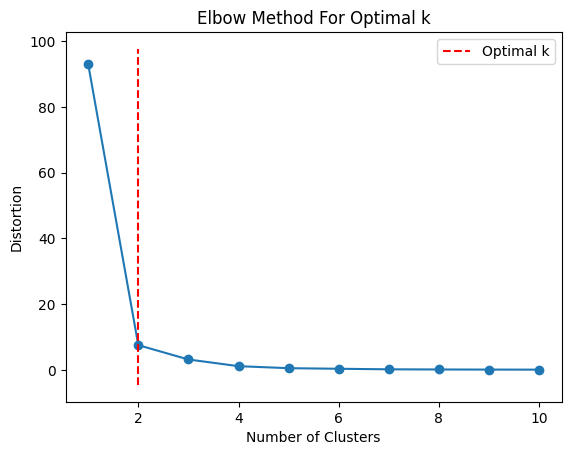

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
target_variable = 'DepDelay'
df = pd.read_csv('masterData.csv', index_col=False, nrows=50000)
df['prcp'].fillna(0, inplace=True)
df.dropna(inplace=True)
df[target_variable] = df[target_variable].apply(lambda x: 0 if x < 0 else x)

categorical_columns = ['Origin', 'Tail_Number', 'OriginCityName', 'Dest', 'DestCityName']
numerical_columns = [col for col in df.columns if col not in [target_variable] + categorical_columns]

# Standardize numerical columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Example for 'Origin' column
unique_values = df['Origin'].unique()

# Create a DataFrame to store aggregated DepDelay values for each unique 'Origin'
agg_df = pd.DataFrame(index=unique_values, columns=['Agg_DepDelay'])

# Aggregate DepDelay for each unique 'Origin'
for value in unique_values:
    agg_df.loc[value, 'Agg_DepDelay'] = df[df['Origin'] == value][target_variable].mean()

# Standardize the aggregated DepDelay values
agg_df['Agg_DepDelay'] = scaler.fit_transform(agg_df[['Agg_DepDelay']])

# Use the elbow method to find the optimal number of clusters
distortions = []
K_range = range(1, 11)  # You can adjust the range as needed

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(agg_df[['Agg_DepDelay']])
    distortions.append(kmeans.inertia_)

# Use KneeLocator to find the optimal number of clusters
kneedle = KneeLocator(K_range, distortions, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow
print(optimal_k)

# Plot the elbow curve with the knee point marked
plt.plot(K_range, distortions, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Optimal k')
plt.legend()
plt.show()

# Rerun KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
agg_df['Cluster'] = kmeans.fit_predict(agg_df[['Agg_DepDelay']])

# Merge the clustering results back to the original DataFrame
df = pd.merge(df, agg_df[['Cluster']], left_on='Origin', right_index=True, how='left')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

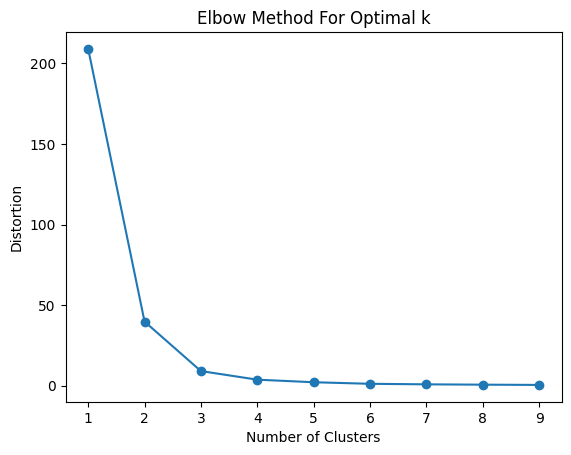

In [ ]:
target_variable = 'DepDelay'
df = pd.read_csv('masterData.csv', index_col=False, nrows=50000)
df['prcp'].fillna(0, inplace=True)
df.dropna(inplace=True)
df[target_variable] = df[target_variable].apply(lambda x: 0 if x < 0 else x)

categorical_columns = ['Origin', 'Tail_Number', 'OriginCityName', 'Dest', 'DestCityName']
numerical_columns = [col for col in df.columns if col not in [target_variable] + categorical_columns]

# Standardize numerical columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Example for 'Origin' column
unique_values = df['DestCityName'].unique()

# Create a DataFrame to store aggregated DepDelay values for each unique 'Origin'
agg_df = pd.DataFrame(index=unique_values, columns=['Agg_DepDelay'])

# Aggregate DepDelay for each unique 'Origin'
for value in unique_values:
    agg_df.loc[value, 'Agg_DepDelay'] = df[df['DestCityName'] == value][target_variable].median()

# Standardize the aggregated DepDelay values
agg_df['Agg_DepDelay'] = scaler.fit_transform(agg_df[['Agg_DepDelay']])

# Use the elbow method to find the optimal number of clusters
distortions = []
K_range = range(1, 10)  # You can adjust the range as needed

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(agg_df[['Agg_DepDelay']])
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(K_range, distortions, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
optimal_k = 3  # Adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
agg_df['Cluster'] = kmeans.fit_predict(agg_df[['Agg_DepDelay']])

# Merge the clustering results back to the original DataFrame
df = pd.merge(df, agg_df[['Cluster']], left_on='Origin', right_index=True, how='left')
df

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Year,Month,DayofMonth,Origin,CRSDepTime,temp,dwpt,rhum,prcp,wdir,...,Flight_Number_Marketing_Airline,Tail_Number,OriginCityName,Dest,DestCityName,DepTime,TaxiOut,TaxiIn,DepDelay,Cluster
29,0.0,0.0,0.511507,EWR,1.225119,0.495386,0.190501,-0.880491,-0.068598,-1.148817,...,0.890049,N11551,"Newark, NJ",CHS,"Charleston, SC",1.161858,1.007158,0.319163,2.0,0
30,0.0,0.0,0.511507,EWR,1.225119,0.495386,0.190501,-0.880491,-0.068598,-1.148817,...,-0.135155,N905DL,"Newark, NJ",ATL,"Atlanta, GA",1.154023,0.363429,0.008636,0.0,0
31,0.0,0.0,0.511507,EWR,1.225119,0.495386,0.190501,-0.880491,-0.068598,-1.148817,...,-0.616925,N78438,"Newark, NJ",DFW,"Dallas/Fort Worth, TX",1.142270,0.773075,-0.146628,0.0,0
49,0.0,0.0,1.150849,EWR,1.204808,0.390631,0.524070,0.423255,-0.041562,1.408895,...,0.890049,N14203,"Newark, NJ",CHS,"Charleston, SC",1.124642,-0.455862,-0.301892,0.0,0
50,0.0,0.0,1.150849,EWR,1.204808,0.390631,0.524070,0.423255,-0.041562,1.408895,...,-0.487083,N12125,"Newark, NJ",SEA,"Seattle, WA",1.130518,-0.280300,0.008636,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49955,0.0,0.0,0.618064,CLT,-0.988753,1.186774,1.377612,0.820047,0.048558,0.221386,...,1.210394,N553NN,"Charlotte, NC",ILM,"Wilmington, NC",-0.984916,0.304909,-0.612419,0.0,0
49956,0.0,0.0,0.618064,CLT,-0.988753,1.186774,1.377612,0.820047,0.048558,0.221386,...,0.449888,N857RW,"Charlotte, NC",EWR,"Newark, NJ",-1.000586,0.187867,0.163899,0.0,0
49957,0.0,0.0,0.618064,CLT,-0.988753,1.186774,1.377612,0.820047,0.048558,0.221386,...,-1.005450,N179UW,"Charlotte, NC",LAS,"Las Vegas, NV",-0.992751,-0.338820,-0.146628,0.0,0
49958,0.0,0.0,0.618064,CLT,-0.988753,1.186774,1.377612,0.820047,0.048558,0.221386,...,1.399893,N716PS,"Charlotte, NC",GSO,"Greensboro/High Point, NC",-0.982958,-0.748466,-0.457155,0.0,0


Origin - 3
Tail Number - 5
OriginCityName - 3
Dest - 4
DestCityName - 4

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Read the data
target_variable = 'DepDelay'
df = pd.read_csv('masterData.csv', index_col=False, nrows=50)
df['prcp'].fillna(0, inplace=True)
df.dropna(inplace=True)
df[target_variable] = df[target_variable].apply(lambda x: 0 if x < 0 else x)

# Define categorical and numerical columns
categorical_columns = ['Origin', 'Tail_Number', 'OriginCityName', 'Dest', 'DestCityName']
numerical_columns = [col for col in df.columns if col not in [target_variable] + categorical_columns]

# Label encode categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[numerical_columns + categorical_columns], df[target_variable], test_size=0.2, random_state=42)

# Standardize numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Convert data to PyTorch tensors
X_train_cat_tensor = torch.tensor(X_train[categorical_columns].values, dtype=torch.long)
X_train_num_tensor = torch.tensor(X_train[numerical_columns].values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_cat_tensor = torch.tensor(X_test[categorical_columns].values, dtype=torch.long)
X_test_num_tensor = torch.tensor(X_test[numerical_columns].values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Send tensors to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_cat_tensor, X_train_num_tensor, y_train_tensor = X_train_cat_tensor.to(device), X_train_num_tensor.to(device), y_train_tensor.to(device)
X_test_cat_tensor, X_test_num_tensor, y_test_tensor = X_test_cat_tensor.to(device), X_test_num_tensor.to(device), y_test_tensor.to(device)

class NeuralNetwork(nn.Module):
    def __init__(self, embedding_sizes, num_numerical_cols, output_size, layers, p=0.5):
        super(NeuralNetwork, self).__init__()

        # Embedding layers for categorical columns
        self.embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_sizes])

        # Total size of embedding output
        embedding_size_total = sum(nf for _, nf in embedding_sizes)

        # Fully connected layers
        self.fc_layers = nn.ModuleList([nn.Linear(num_numerical_cols + embedding_size_total if i == 0 else layers[i-1], layers[i]) for i in range(len(layers))])

        # Output layer
        self.output = nn.Linear(layers[-1], output_size)

        # Dropout layer
        self.dropout = nn.Dropout(p)

    def forward(self, x_cat, x_num):
        # Embedding categorical columns
        embeddings = [embed(x_cat[:, i]) for i, embed in enumerate(self.embeddings)]
        x = torch.cat(embeddings, 1)

        # Concatenate embeddings and numerical columns
        x = torch.cat([x, x_num], 1)

        # Apply dropout
        x = self.dropout(x)

        # Pass through fully connected layers
        for layer in self.fc_layers:
            x = layer(x)
            x = nn.ReLU()(x)
            x = self.dropout(x)

        # Output layer
        x = self.output(x)
        return x


# Define the embedding sizes for categorical columns
embedding_sizes = [(len(df[col].unique()), min(50, len(df[col].unique())//2 + 1)) for col in categorical_columns]

# Instantiate the model
model = NeuralNetwork(embedding_sizes, len(numerical_columns), 1, [100, 50, 30, 10], p=0.3)

# Send the model to the GPU if available
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Batch size
batch_size = 32

# Modify DataLoader instantiation with the specified batch size
train_dataset = torch.utils.data.TensorDataset(X_train_cat_tensor, X_train_num_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

epochs = 1
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Iterate over batches
    for batch_cat, batch_num, batch_y in train_loader:
        # Pass categorical and numerical tensors separately
        y_pred = model(batch_cat, batch_num)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_cat_tensor, X_test_num_tensor)
        val_loss = criterion(y_val_pred, y_test_tensor)

        # Convert predictions and ground truth to numpy arrays
        y_val_np = y_test_tensor.cpu().numpy()
        y_val_pred_np = y_val_pred.cpu().numpy()

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val_np, y_val_pred_np))
        mae = mean_absolute_error(y_val_np, y_val_pred_np)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, RMSE: {rmse}, MAE: {mae}')


Epoch 1/1, Loss: 1.2606600522994995, Validation Loss: 0.009759515523910522, RMSE: 0.0987902581691742, MAE: 0.0987902581691742


In [ ]:
# def print_model_architecture(model):
#     print(model)
#     print("Model Architecture:")
#     for name, layer in model.named_children():
#         print(f"Layer Name: {name}")
#         print(layer)
#         print("-" * 50)

# # Example usage
# print_model_architecture(model)